In [2]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import wordcloud
import Uncertainty as unc
import UncertaintyM as uncM
import matplotlib.pyplot as plt
import data_provider as dp
from classes.wordclouds import Wordcloud
from wordcloud import STOPWORDS

In [3]:
episodes = 100
test_split = 0.3
log = True
unc_plot = False
seed = 1

In [4]:
# load the data
features_all, targets_all, text_all = dp.load_data("./Data/")
features_list, targets_list, text_list = dp.partition_data(features_all, targets_all, text_all, episodes)

episode  0
------------------------------------
model test score =  0.6249201550057488
High epist :  [1.33185821 1.11778514 1.10449895 1.0990547  1.0990547  1.0982096
 1.08750548 1.08141028 1.07065899 1.06686202]
Low epist :  [0.01903339 0.01903256 0.01900888 0.01876691 0.01856865 0.0175893
 0.01716417 0.01716417 0.01716417 0.01363898]


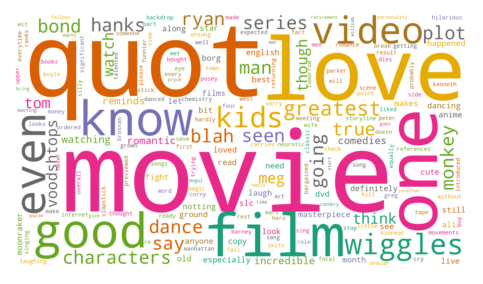

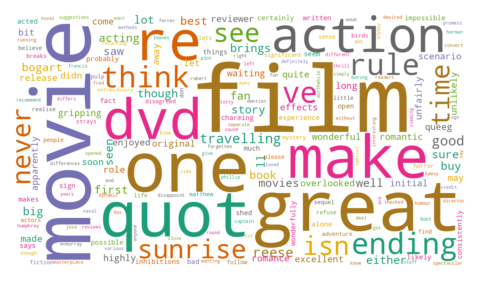

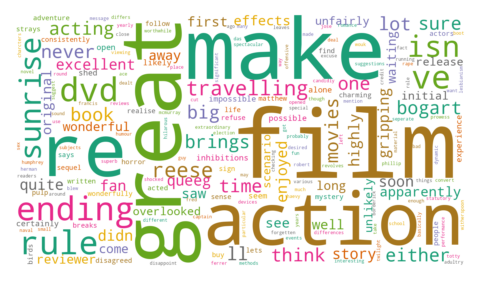

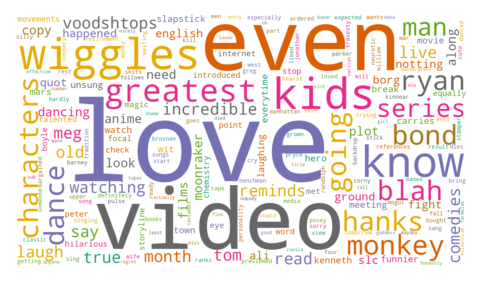

In [12]:
for episode, (features, targets, texts) in enumerate(zip(features_list, targets_list, text_list)):

    print("episode ", episode)
    print("------------------------------------")

    # split and shuffel the data
    X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size=test_split, shuffle=False, random_state=seed)
    _,       text_test, _   , _      = train_test_split(texts,    targets, test_size=test_split, shuffle=False, random_state=seed)

    # train the model
    model = RandomForestClassifier(max_depth=10, n_estimators=10, random_state=1)
    model.fit(X_train, y_train[:,0]) # remove keys when fiting the model

    predictions = model.predict(X_test)
    if log:
        print("model test score = ", model.score(X_test, y_test[:,0]))

    # Aleatoric uncertianty for X_test
    total_uncertainty, epistemic_uncertainty, aleatoric_uncertainty = unc.model_uncertainty(model, X_test, X_train, y_train[:,0])

    # AR plot
    if unc_plot:
        avg_acc, avg_min, avg_max, avg_random ,steps = uncM.accuracy_rejection2(predictions.reshape((1,-1)), y_test[:,0].reshape((1,-1)), total_uncertainty.reshape((1,-1)))
        plt.plot(steps, avg_acc*100)
        plt.savefig(f"./Results/AR_plot.png",bbox_inches='tight')

    # sort based on uncertianty
    sorted_index = np.argsort(-total_uncertainty, kind='stable')
    text_test = np.array(text_test)
    text_test = text_test[sorted_index]
    # epistemic_uncertainty = epistemic_uncertainty[sorted_index]

    # Create wordcloud

    wordcloud_text_array = text_test[:10]
    wordcloud = Wordcloud()
    tokens_a = wordcloud.get_tokens(list(wordcloud_text_array))
    # cloud = wordcloud.get_wordcloud(tokens_a)
    # wordcloud.plot(cloud, f"test_high_epist_e{episode}")
    # if log:
    #     print("High epist : ", epistemic_uncertainty[:10])

    wordcloud_text_array = text_test[-10:]
    wordcloud = Wordcloud()
    tokens_b = wordcloud.get_tokens(list(wordcloud_text_array))
    # cloud = wordcloud.get_wordcloud(tokens_b)
    # wordcloud.plot(cloud, f"test_low_epist_e{episode}")
    # if log:
    #     print("Low epist : ", epistemic_uncertainty[-10:])

    wordcloud = Wordcloud()
    tokens_c = tokens_b - tokens_a
    cloud = wordcloud.get_wordcloud(tokens_c)
    wordcloud.plot(cloud, f"LowsubHigh_{episode}")

    wordcloud = Wordcloud()
    tokens_c = tokens_a - tokens_b
    cloud = wordcloud.get_wordcloud(tokens_c)
    wordcloud.plot(cloud, f"HighsubLow_{episode}")


    break
    
